In [1]:
import gzip
import theano
import cPickle
import matplotlib
import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu0")


with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = cPickle.load(f)
    

def shared_dataset(data_xy):
    data_x, data_y = data_xy
    return theano.shared(data_x), theano.shared(data_y)


test_set_x, test_set_y = shared_dataset(test_set)
valid_set_x, valid_set_y = shared_dataset(valid_set)
train_set_x, train_set_y = shared_dataset(train_set)
batch_size = 500
train_data_set_size = len(train_set[0])
val_data_set_size = len(valid_set[0])
test_data_set_size = len(test_set[0])

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled)


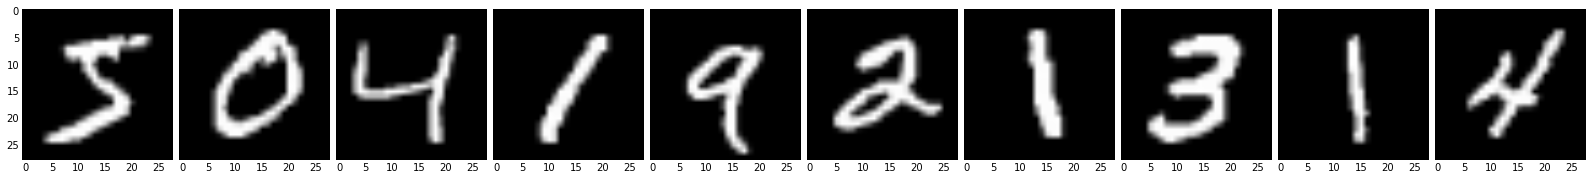

In [2]:
fig = plt.figure(1, (28., 28.))
grid = ImageGrid(fig, 111, nrows_ncols = (1, 10), axes_pad=0.1)

for c in range(10):
    image_array = train_set[0][c].reshape((28, 28))
    grid[c].imshow(image_array, cmap=plt.cm.gray)

In [3]:
from theano import tensor as T
from theano.tensor.nnet import conv
from theano.tensor.signal.downsample import max_pool_2d


def rectify(x):
    return T.maximum(x, 0.)


class DenseLayer(object):
    def __init__(self, w_init):
        self.W = theano.shared(w_init())
        
    def get_output_expr(self, input_expr):
        pre_rectify_expr = T.dot(input_expr, self.W)
        return rectify(pre_rectify_expr)

    def get_parameters(self):
        return [self.W]


class LogisticRegresion(object):
    def __init__(self, w_init):
        self.W = theano.shared(w_init())
        
    def get_output_expr(self, input_expr):
        pre_softmax_expr = T.dot(input_expr, self.W)
        return T.nnet.softmax(pre_softmax_expr)

    def get_parameters(self):
        return [self.W]
                
    
class ConvPoolLayer(object):
    def __init__(self, w_init):
        self.W = theano.shared(w_init())
                              
    def get_output_expr(self, input_expr):
        conv_out = conv.conv2d(input_expr, self.W)
        pooled_out = max_pool_2d(conv_out, (2, 2))
        return rectify(pooled_out)
                              
    def get_parameters(self):
        return [self.W]
    

def get_sgd_updates(cost, params, lr=np.float32(0.05)):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - lr * g])
    return updates    

In [5]:
X = T.fmatrix()
y = T.lvector()
batch_index = T.iscalar()

# 4D tensor corresponding to a mini-batch of input images. The shape of the tensor is as follows: 
# [mini-batch size, number of input feature maps, image height, image width]
# 4D tensor corresponding to the weight matrix W. The shape of the tensor is: 
# [number of feature maps at layer m, number of feature maps at layer m-1, filter height, filter width]
layer0_input = X.reshape((batch_size, 1, 28, 28)) 
w_init = lambda: (np.random.randn(32, 1, 3, 3) * 0.01).astype(np.float32)
layer0 = ConvPoolLayer(w_init)
w_init = lambda: (np.random.randn(64, 32, 3, 3) * 0.01).astype(np.float32)
layer1 = ConvPoolLayer(w_init)
w_init = lambda: (np.random.randn(64 * 6 * 6, 600) * 0.01).astype(np.float32)
dense_layer = DenseLayer(w_init)
w_init = lambda: (np.random.randn(600, 10) * 0.01).astype(np.float32)
lr_layer = LogisticRegresion(w_init)


layer0_expr = layer0.get_output_expr(layer0_input)
layer1_expr = layer1.get_output_expr(layer0_expr)
dense_expr = dense_layer.get_output_expr(layer1_expr.flatten(2))
py_x = lr_layer.get_output_expr(dense_expr)
y_pred = T.argmax(py_x, axis=1)
cost = T.mean(T.nnet.categorical_crossentropy(py_x, y))


updates = get_sgd_updates(cost, layer0.get_parameters() + layer1.get_parameters() + dense_layer.get_parameters() + lr_layer.get_parameters())
train = theano.function(inputs=[batch_index], outputs=cost, updates=updates, 
                        givens={X: train_set_x[batch_index * batch_size:(batch_index + 1) * batch_size],
                                y: train_set_y[batch_index * batch_size:(batch_index + 1) * batch_size]})
val = theano.function(inputs=[batch_index], outputs=cost, 
                      givens={X: valid_set_x[batch_index * batch_size:(batch_index + 1) * batch_size], 
                              y: valid_set_y[batch_index * batch_size:(batch_index + 1) * batch_size]})
get_prediction_accuracy = theano.function(inputs=[batch_index], outputs=T.mean(T.eq(y_pred, y)), 
                                          givens={X: test_set_x[batch_index * batch_size:(batch_index + 1) * batch_size], 
                                                  y: test_set_y[batch_index * batch_size:(batch_index + 1) * batch_size]})

In [6]:
for i in range(100):
    for index in range(train_data_set_size / batch_size):
        cost = train(index)
    if i % 10 == 0:
        cost = []
        acc = []
        for index in range(val_data_set_size / batch_size):
            cost.append(val(index))
        for index in range(test_data_set_size / batch_size):
            acc.append(get_prediction_accuracy(index))
        print i, np.mean(cost), np.mean(acc)

0 2.30257 0.0636
10 0.792317 0.7299
20 0.108261 0.9663
30 0.0743284 0.9773
40 0.0641644 0.9827
50 0.0604711 0.9838
60 0.0595902 0.9851
70 0.0604358 0.9858
80 0.0620983 0.9858
90 0.0633274 0.9862
100 0.0645694 0.9868
110 0.0662597 0.9869
120 0.0687656 0.9865
130 0.0704775 0.9868
140 0.07194 0.9866
